In [ ]:
# An example of how a cross sectional area is produced and used for wave propagation.
# This script visualises each step, but is NOT used to produce the final train/ test data

In [ ]:
pip install torch

In [ ]:
pip install --user git+https://github.com/devitocodes/devito.git

In [1]:
import os

In [2]:
os.environ['DEVITO_LANGUAGE'] = 'openmp'

os.environ['OMP_SCHEDULE'] = 'STATIC'

os.environ['OMP_PROC_BIND'] = 'true'

os.environ['OMP_PLACES'] = 'cores'

In [3]:
# import libraries and tools
import torch
import numpy as np
import h5py
from time import perf_counter
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.animation as animation
from IPython.display import HTML
from devito import Grid, TimeFunction, Operator, Constant, Eq, solve, first_derivative, left
from examples.seismic import Model
from examples.seismic import TimeAxis
from examples.seismic import RickerSource
from examples.seismic import Receiver
from examples.seismic import plot_velocity, plot_shotrecord

In [6]:
# Each cross sectional area is size 5km x 3.5km
extent_x = 5.e3  
extent_z = 35.e2  

# Each cross sectional area has 201 x 207 nodes
nx = 201  
nz = 207 

# Damping layer is 20m
absorbingLayer = 20 

dx = extent_x / (nx-1) # metres
dz = extent_z / (nz-1) # metres

shape = (nx, nz)
spacing = (dx, dz)
origin = (0., 0.)

# create velocity model from 3D overthrust model
hf = h5py.File('overthrust_3D_true_model.h5', 'r')
m = hf['m']
m2 = np.array(m)
m2 = np.transpose(m2, (1,2,0)) 

print(m2.shape)
# Taking the 3rd larger cross sectional area (out of 801), 
# and then taking the 2nd "chunk" of that cross sectional area (out of 4)
# Gives a cross sectional area of size (207, 201)
v = m2[200:401 , 3, :]
# Reverse squared slowness to get original velocity
v = 1/np.sqrt(v) 

# Take a 64 x 64 sample of the velocity model to use for wave propagation
v2 = v[74:138,74:138]

# Initiate Velocity Model

model_full = Model(vp=v, origin=origin, shape=shape, spacing=spacing,
             space_order=2, nbl=absorbingLayer, bcs="damp")

model = Model(vp=v2, origin=origin, shape=(64,64), spacing=spacing,
              space_order=2, nbl=absorbingLayer, bcs="damp")

t0 = 0.  # Milliseconds
dt = model.critical_dt
print(dt)
T = 1000 # Milliseconds
nt = int(((T ) / dt))
print(nt)
time_range = TimeAxis(start=t0, stop=T, step =dt)

(801, 801, 207)


Operator `initdamp` ran in 0.01 s
Operator `pad_vp` ran in 0.01 s
Operator `initdamp` ran in 0.01 s
Operator `pad_vp` ran in 0.01 s


1.892
528


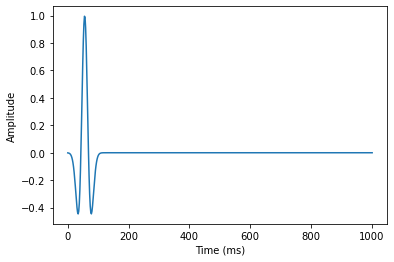

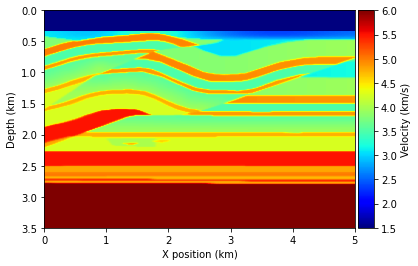

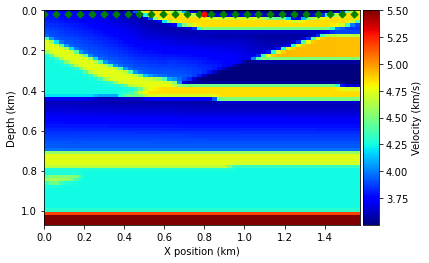

In [7]:
# Source peak frequency
f0 = 0.018 # 18Hz (0.018 kHz) 

# Single source at the top
src = RickerSource(name='src', grid=model.grid, f0=f0,
                   npoint=1, time_range=time_range)

# Source co-ordinates
src.coordinates.data[0, 0] = 800 # Metres
src.coordinates.data[0, 1] = 20 # Metres

# 107 Receivers at the top
rec = Receiver(name='rec', grid=model.grid, npoint=107, time_range=time_range)

# Receiver co-ordinates 
rec.coordinates.data[:, 0] = np.linspace(0, model.domain_size[0], num=107) # Metres
rec.coordinates.data[:, 1] = 20 # Metres

# Code below adds receivers at the bottom, better for FWI, less reflections
#rec.coordinates.data[:, 0] =  extent_x -20 # Metres
#rec.coordinates.data[:, 1] = np.linspace(0, model.domain_size[0], num=107)  # Metres

# Wave equation for propagation
u = TimeFunction(name="u", grid=model.grid, time_order=2, space_order=2, save=nt + 2)
pde = model.m * u.dt2 - u.laplace + model.damp * u.dt
stencil = Eq(u.forward, solve(pde, u.forward))

src_term = src.inject(field=u.forward, expr=src*dt**2 / model.m)
rec_term = rec.interpolate(expr=u)

op = Operator([stencil] + src_term + rec_term) 
# Show the source wavelet
src.show()
# Show the Velocity model of the cross sectional area
plot_velocity(model_full)

# Show 64 x 64 velocity model within cross sectional area
plot_velocity(model, source=src.coordinates.data, receiver=rec.coordinates.data[::4, :])


In [8]:
# generate solution
op(time=nt, dt=dt)

Operator `Kernel` ran in 0.02 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=0.010524999999999984, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section1', rank=None),
                     PerfEntry(time=0.0015209999999999948, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section2', rank=None),
                     PerfEntry(time=0.0020350000000000125, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

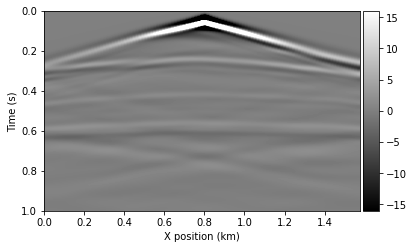

(530, 107)


In [9]:
# Show shot record 
plot_shotrecord(rec.data, model, 0, T)
print(rec.data.shape)

In [10]:
# Create a gif of the wave propagating through the cross sectional velocity model
fig = plt.figure()
im = plt.imshow(np.transpose(u.data[0,40:-40,40:-40]),
                cmap="Greys", animated=True, vmin=-15, vmax=15, aspect=1,
                extent=[model.origin[0], model.origin[0] + 1e-3 * model.shape[0] * model.spacing[0],
                        model.origin[1] + 1e-3*model.shape[1] * model.spacing[1], model.origin[1]])
plt.xlabel('x- position (km)',  fontsize=10)
plt.ylabel('Depth (km)',  fontsize=10)
plt.tick_params(labelsize=10)
im2 = plt.imshow(np.transpose(v2), vmin=1.5, vmax=6, cmap=cm.GnBu, aspect=1,
                 extent=[model.origin[0], model.origin[0] + 1e-3 * model.shape[0] * model.spacing[0],
                         model.origin[1] + 1e-3*model.shape[1] * model.spacing[1], model.origin[1]], alpha=.4)
def updatefig(i):
    im.set_array(np.transpose(u.data[i*5,40:-40,40:-40]))
    return im, im2

ani = animation.FuncAnimation(fig, updatefig, frames=np.linspace(0, nt/5-1, nt//5, dtype=np.int64), blit=True, interval=50)
plt.close(ani._fig)
HTML(ani.to_html5_video())

In [11]:
print("output shape:", u.data.shape)

output shape: (530, 104, 104)


In [12]:
print("input shape:", v.shape)

input shape: (201, 207)


In [ ]:
ani.save('waveanimation.gif', writer='imagemagick', fps=30)